In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import time  # For rendering delays
import imageio


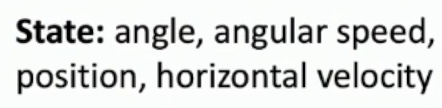

In [ ]:
# Define the Q-network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the replay buffer
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.batch_size = 64
        self.buffer_size = 10000

        self.q_network = QNetwork(state_size, action_size)
        self.target_network = QNetwork(state_size, action_size)
        self.optimizer = optim.Adam(
            self.q_network.parameters(), lr=self.learning_rate)
        self.replay_buffer = ReplayBuffer(self.buffer_size)

        # Update the target network initially
        self.update_target_network()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.q_network(state)
        return torch.argmax(q_values).item()

    def train(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        batch = self.replay_buffer.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        # Compute the target Q-values
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + \
                (self.gamma * next_q_values * (1 - dones))

        # Compute the current Q-values
        q_values = self.q_network(states).gather(
            1, actions.unsqueeze(1)).squeeze(1)

        # Compute loss and optimize
        loss = nn.MSELoss()(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Main training loop
def train_cartpole():
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(state_size, action_size)
    episodes = 1500
    target_update_freq = 10

    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0

        while True:
            action = agent.get_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            total_reward += reward

            agent.replay_buffer.add((state, action, reward, next_state, done))
            state = next_state

            if done or truncated:
                break

            agent.train()

        # Update the target network
        if episode % target_update_freq == 0:
            agent.update_target_network()

        if episode % 100 == 1:
            print(
                f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")

        if total_reward >= 500:
            render_cartpole(agent)
            break

    env.close()


# Function to render the CartPole environment after training
def render_cartpole(agent):
    env = gym.make('CartPole-v1', render_mode="rgb_array")
    state, _ = env.reset()

    frames = []  # To store frames for the video
    while True:
        frame = env.render()
        frames.append(frame)  # Capture each frame

        action = agent.get_action(state)
        state, _, done, truncated, _ = env.step(action)

        if done or truncated:
            break

    env.close()

    # Save frames as MP4
    save_video(frames, "cartpole_output.mp4")


def save_video(frames, filename):
    fps = 30  # Frames per second
    imageio.mimwrite(filename, frames, fps=fps)
    print(f"Video saved as {filename}")

In [ ]:
train_cartpole()

# Practice

In [ ]:
class ContinuousCartPoleEnv(gym.Env):
    def __init__(self):
        # Enable RGB rendering
        self.env = gym.make("CartPole-v1", render_mode="rgb_array")
        self.action_space = gym.spaces.Box(
            low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = self.env.observation_space

    def step(self, action):
        # Smoothly map [-1, 1] to continuous force
        force = (action + 1) / 2  # Scale to [0, 1]
        discrete_action = 0 if force < 0.5 else 1
        obs, reward, done, truncated, info = self.env.step(discrete_action)
        # Scale reward for better gradients
        reward = (reward - 0.5) * 2  # Center around 0
        return obs, reward, done, truncated, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

    def render(self):
        return self.env.render()  # Returns RGB frame data for video saving

    def close(self):
        self.env.close()


class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim),
            nn.Tanh()
        )
        self.max_action = max_action

    def forward(self, state):
        return self.max_action * self.network(state)


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        return self.network(x)


class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones)
        )

    def __len__(self):
        return len(self.buffer)


class OrnsteinUhlenbeckNoise:
    def __init__(self, action_dim, mu=0, theta=0.15, sigma=0.2):
        self.action_dim = action_dim
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dim) * self.mu

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def sample(self):
        dx = self.theta * (self.mu - self.state) + \
            self.sigma * np.random.randn(self.action_dim)
        self.state += dx
        return self.state


class DDPGAgent:
    def __init__(self, state_dim, action_dim, max_action, gamma=0.99, tau=0.005):
        self.actor = Actor(state_dim, action_dim, max_action).float()
        self.actor_target = Actor(state_dim, action_dim, max_action).float()
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-3)

        self.critic = Critic(state_dim, action_dim).float()
        self.critic_target = Critic(state_dim, action_dim).float()
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        self.gamma = gamma
        self.tau = tau
        self.replay_buffer = ReplayBuffer(size=1000000)
        self.noise = OrnsteinUhlenbeckNoise(action_dim)

    def select_action(self, state, explore=True):
        state = torch.FloatTensor(state).unsqueeze(0)
        action = self.actor(state).detach().cpu().numpy().flatten()
        if explore:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def train(self, batch_size=64):
        if len(self.replay_buffer) < batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(
            batch_size)
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        with torch.no_grad():
            target_actions = self.actor_target(next_states)
            target_q = self.critic_target(next_states, target_actions)
            target_q = rewards + (1 - dones) * self.gamma * target_q

        current_q = self.critic(states, actions)
        critic_loss = nn.MSELoss()(current_q, target_q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actor_loss = -self.critic(states, self.actor(states)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(
                self.tau * param.data + (1 - self.tau) * target_param.data)

        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(
                self.tau * param.data + (1 - self.tau) * target_param.data)


def train_ddpg(env, agent, episodes=2000, batch_size=64):
    for episode in range(episodes):
        state, _ = env.reset()
        agent.noise.reset()
        episode_reward = 0
        done = False

        # Capture frames for the last episode
        frames = []

        while not done:
            # if episode == episodes - 1:  # Only render the last episode
            frame = env.render()
            frames.append(frame)

            action = agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            agent.replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward

            agent.train(batch_size)

        print(f"Episode {episode + 1}, Reward: {episode_reward}")

        # Save video for the last episode
        if episode_reward >= 600:
            save_video(frames, "ddpg_cartpole1.mp4")
            break

    env.close()


# Function to save video frames as MP4
def save_video(frames, filename):
    fps = 30  # Frames per second
    imageio.mimwrite(filename, frames, fps=fps)
    print(f"Video saved as {filename}")

In [ ]:
env = ContinuousCartPoleEnv()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

agent = DDPGAgent(state_dim, action_dim, max_action)

train_ddpg(env, agent, episodes=5000)

این الگوریتم بسیار سخت تر ترین میشود و نتیجه خروجی نیز به خوبی الگوریتم اول خوب نیست.